<h1 style="text-align: center;">Facial Recognition with <strong><em>Siamese Network</em></strong> on Yale Faces dataset</h1>

- The `siamese network` is model that utilizes a cost function that aims to minimize the distance between any two images of the same person, while maximizing the distance between pictures of any two different people.
- Pairs of images are passed through the model and the model makes a prediction of the distance between them. The distance is passed through the cost function for which the model is penalized more for predicting large distances for similar images and small instances for disimilar images.
- A plot of the distributions of the distances for similar and distances for disimilar images, as shown in the last few lines gives a pictorial method of gauging the performance of the model. The farther apart the distributions are, the more likely the model is performing well

Dataset can be downloaded [here](https://www.kaggle.com/datasets/olgabelitskaya/yale-face-database)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from glob import glob

import tensorflow as tf
from keras.preprocessing import image
import keras.utils as utils

import re
import math
from collections import Counter
from itertools import combinations, combinations_with_replacement, product
from datetime import datetime

In [2]:
## getting all filenames
data_path = "(path to dataset)"
filenames = glob(f"{data_path}/*")

## shuffling the filenames
np.random.shuffle(filenames)

In [3]:
## setting width and height of each image
H,W = 60, 80

In [4]:
def load_image(filename):
    return utils.img_to_array(utils.load_img(filename, target_size=[H,W])).mean(-1).astype(np.uint8)

def get_labels(filenames):
    return [int(re.search("\\\\subject(\d+)", filename).groups(0)[0])-1 for filename in filenames]

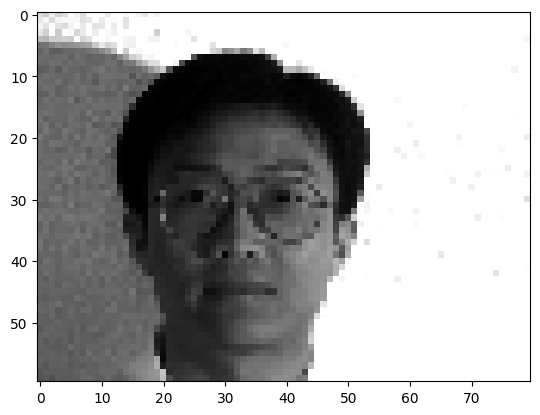

In [5]:
plt.imshow(load_image(np.random.choice(filenames)), cmap="gray")
plt.show()

In [6]:

N = len(filenames)

In [7]:
## getting images as numpy arrays
images = np.zeros((N, H, W))
for i in range(len(filenames)):
    images[i] = load_image(filenames[i])/255.

## getting labels of each image
labels = get_labels(filenames)

In [8]:
## checking number of items in each of the train test split to decide how to split
Counter(labels)

Counter({11: 11,
         10: 11,
         14: 11,
         6: 11,
         7: 11,
         13: 11,
         5: 11,
         2: 11,
         4: 11,
         8: 11,
         3: 11,
         1: 11,
         0: 11,
         12: 11,
         9: 11})

In [9]:
## since each subject has same number of images, use fixed size per subject for each subject in test data

In [10]:
## getting the indices where each label is found to make pairs
test_idxs = {}
train_idxs = {}
test_size = 3

for idx, label in enumerate(labels):
    ar = test_idxs.get(label, [])
    if len(ar) < test_size:
        ar.append(idx)
        test_idxs[label] = ar
    else:
        ar = train_idxs.get(label, [])
        ar.append(idx)
        train_idxs[label] = ar

del ar

In [11]:
def generate_pairs(idxs_dict):
    pos_pairs = []
    neg_pairs = []

    # for k in idxs_dict:
    #     pos_pairs += combinations(idxs_dict[k],2)
    for a, b in combinations_with_replacement(idxs_dict, 2):
        if a == b: pos_pairs += combinations(idxs_dict[a],2)
        else: neg_pairs += product(idxs_dict[a], idxs_dict[b])

    return pos_pairs, neg_pairs

In [12]:
## getting the positive and negative matches for both train and test data
train_pos_pairs, train_neg_pairs = generate_pairs(train_idxs)
test_pos_pairs, test_neg_pairs = generate_pairs(test_idxs)

In [13]:
len(train_pos_pairs), len(train_neg_pairs)

(420, 6720)

In [14]:
len(test_pos_pairs), len(test_neg_pairs)

(45, 945)

In [15]:
def pair_generator(pos_pairs, neg_pairs, images, shuffle=False, batch_size=64):
    n_batches = int(np.ceil(len(pos_pairs)/batch_size))
    img_shape = images[0].shape
    while True:
        if shuffle: np.random.shuffle(pos_pairs)
        x_batch_1 = np.zeros((batch_size*2, *img_shape))
        x_batch_2 = np.zeros((batch_size*2, *img_shape))
        y_batch = np.zeros(batch_size*2)


        for i in range(n_batches):
            batch_pos_pairs = pos_pairs[i*batch_size:(i+1)*batch_size]
            j = 0
            for idx1, idx2 in batch_pos_pairs:
                x_batch_1[j] = images[idx1]
                x_batch_2[j] = images[idx2]
                y_batch[j] = 1
                j+=1

            ## if-condition to allow selection with replacement in the event that the number positive pairs
            ## are greater than the number of negative pairs
            neg_idxs = np.random.choice(len(neg_pairs), size=len(batch_pos_pairs), replace=False if len(neg_pairs) > len(batch_pos_pairs) else True)
            for neg in neg_idxs:
                idx1, idx2 = neg_pairs[neg]
                x_batch_1[j] = images[idx1]
                x_batch_2[j] = images[idx2]
                y_batch[j] = 0
                j+=1

            ## batch data only up to index j
            x1 = x_batch_1[:j].reshape(-1,1,*img_shape).astype(np.float32)
            x2 = x_batch_2[:j].reshape(-1,1,*img_shape).astype(np.float32)
            y = y_batch[:j].astype(np.float32)

            ## converting to tensors
            x1 = torch.from_numpy(x1)
            x2 = torch.from_numpy(x2)
            y = torch.from_numpy(y)

            
            yield [x1, x2], y

In [16]:
batch_size = 64
train_generator = lambda: pair_generator(train_pos_pairs, train_neg_pairs, images, shuffle=True, batch_size=batch_size)
test_generator = lambda: pair_generator(test_pos_pairs, test_neg_pairs, images, shuffle=False, batch_size=batch_size)

In [17]:
class SiameseNN(nn.Module):
    def __init__(self, vector_space_size=50):
        super(SiameseNN, self).__init__()
        self.V = vector_space_size

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(13*18*64, 128),
            nn.ReLU(),
            nn.Linear(128, self.V)
        )

    def forward(self, img1, img2):
        feat1, feat2 = self.cnn(img1), self.cnn(img2)
        
        ## returning euclidean distance between both image embeddings
        return torch.linalg.norm(feat2-feat1, dim=-1)

In [18]:
## creating criterion yd**2 + (1-y)max(m-d, 0)
def criterion(d, y):
    ## for non matches, distance between image embedding should be ideally at least 1
    non_match = F.relu(1-d)
    return torch.mean(y*d**2 + (1-y)*non_match**2)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
model = SiameseNN(50)
model.to(device)

SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [21]:
optimizer = torch.optim.Adam(model.parameters())

In [22]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, train_steps=2, test_steps=2, epochs=20):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        steps = 0
        epoch_losses = []
        for [inputs1, inputs2], targets in train_loader:
            optimizer.zero_grad()
            inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
            epoch_losses.append(loss.item())
    
            steps+=1
            if steps >= train_steps: break;

        train_losses[it] = np.mean(epoch_losses)
        
        steps = 0
        epoch_losses = []
        for [inputs1, inputs2], targets in test_loader:
            inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, targets)
    
            epoch_losses.append(loss.item())
    
            steps+=1
            if steps >= test_steps: break;

        test_losses[it] = np.mean(epoch_losses)

        dt = datetime.now() - t0

        print(f"Epoch: {it+1}/{epochs}, Train loss: {train_losses[it]}, Test Loss: {test_losses[it]}, Duration: {dt}")

    return train_losses, test_losses

In [23]:
train_steps = int(np.ceil(len(train_pos_pairs)/batch_size))
test_steps = int(np.ceil(len(test_pos_pairs)/batch_size))

train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_generator(), test_generator(), train_steps=train_steps, test_steps=test_steps
)

Epoch: 1/20, Train loss: 0.6854980098349708, Test Loss: 0.31797727942466736, Duration: 0:00:19.999091
Epoch: 2/20, Train loss: 0.22758211621216365, Test Loss: 0.3033442497253418, Duration: 0:00:20.294130
Epoch: 3/20, Train loss: 0.1518760078719684, Test Loss: 0.23646430671215057, Duration: 0:00:22.497397
Epoch: 4/20, Train loss: 0.09009936664785657, Test Loss: 0.18902894854545593, Duration: 0:00:21.404243
Epoch: 5/20, Train loss: 0.059176323137113025, Test Loss: 0.2255759835243225, Duration: 0:00:21.129380
Epoch: 6/20, Train loss: 0.04087700854454722, Test Loss: 0.16542194783687592, Duration: 0:00:21.153297
Epoch: 7/20, Train loss: 0.02292526194027492, Test Loss: 0.1992633193731308, Duration: 0:00:19.627021
Epoch: 8/20, Train loss: 0.018957064487040043, Test Loss: 0.20246510207653046, Duration: 0:00:20.487726
Epoch: 9/20, Train loss: 0.011027889459260873, Test Loss: 0.16790278255939484, Duration: 0:00:19.651884
Epoch: 10/20, Train loss: 0.00890485949016043, Test Loss: 0.172539532184600

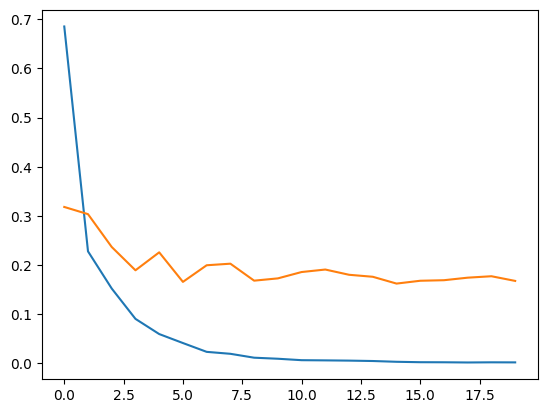

In [24]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

In [25]:
def predict(x1, x2):
    with torch.no_grad():
        x1 = torch.from_numpy(x1.reshape(-1,1, H,W).astype(np.float32))
        x2 = torch.from_numpy(x2.reshape(-1,1, H,W).astype(np.float32))

        return model(x1,x2)

In [26]:
def get_accuracy(pos_pairs, neg_pairs, images, threshold=0.85, batch_size=64):
    tp = 0 ## +ve and I say it is
    tn = 0 ## -ve and I say it is
    fp = 0 ## -ve but I say +ve
    fn = 0 ## +ve but I say -ve

    pos_distances = []
    neg_distances = []

    img_shape = images[0].shape
    x_batch_1 = np.zeros((batch_size, *img_shape))
    x_batch_2 = np.zeros((batch_size, *img_shape))

    n_batches = int(np.ceil(len(pos_pairs)/batch_size))
    for i in range(n_batches):
        print(f"Positive Batch: {i+1}/{n_batches}")
        pos_batch_pairs = pos_pairs[i*batch_size:(i+1)*batch_size]

        j = 0
        for idx1, idx2 in pos_batch_pairs:
            x_batch_1[j] = images[idx1]
            x_batch_2[j] = images[idx2]
            j+=1

        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]

        distances = predict(x1, x2)

        tp += (distances < threshold).sum().item()
        fn += (distances > threshold).sum().item()
        
        pos_distances += distances.tolist()
        
    n_batches = int(np.ceil(len(neg_pairs)/batch_size))
    for i in range(n_batches):
        print(f"Negative Batch: {i+1}/{n_batches}")
        neg_batch_pairs = neg_pairs[i*batch_size:(i+1)*batch_size]

        j = 0
        for idx1, idx2 in neg_batch_pairs:
            x_batch_1[j] = images[idx1]
            x_batch_2[j] = images[idx2]
            j+=1

        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]

        distances = predict(x1, x2)

        tn += (distances > threshold).sum().item()
        fp += (distances < threshold).sum().item()
        
        neg_distances += distances.tolist()


    ## getting true-positive rate and false-negative rate
    tpr = tp/(tp + fn)
    tnr = tn/(tn + fp)

    print(f"Sensitivity: {tpr}, Specificity: {tnr}")

    return pos_distances, neg_distances

In [27]:
train_pos_distances, train_neg_distances = get_accuracy(train_pos_pairs, train_neg_pairs, images, threshold=0.65)

Positive Batch: 1/7
Positive Batch: 2/7
Positive Batch: 3/7
Positive Batch: 4/7
Positive Batch: 5/7
Positive Batch: 6/7
Positive Batch: 7/7
Negative Batch: 1/105
Negative Batch: 2/105
Negative Batch: 3/105
Negative Batch: 4/105
Negative Batch: 5/105
Negative Batch: 6/105
Negative Batch: 7/105
Negative Batch: 8/105
Negative Batch: 9/105
Negative Batch: 10/105
Negative Batch: 11/105
Negative Batch: 12/105
Negative Batch: 13/105
Negative Batch: 14/105
Negative Batch: 15/105
Negative Batch: 16/105
Negative Batch: 17/105
Negative Batch: 18/105
Negative Batch: 19/105
Negative Batch: 20/105
Negative Batch: 21/105
Negative Batch: 22/105
Negative Batch: 23/105
Negative Batch: 24/105
Negative Batch: 25/105
Negative Batch: 26/105
Negative Batch: 27/105
Negative Batch: 28/105
Negative Batch: 29/105
Negative Batch: 30/105
Negative Batch: 31/105
Negative Batch: 32/105
Negative Batch: 33/105
Negative Batch: 34/105
Negative Batch: 35/105
Negative Batch: 36/105
Negative Batch: 37/105
Negative Batch: 38

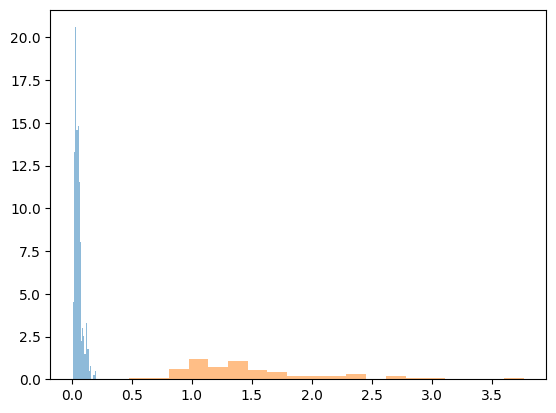

In [28]:
plt.hist(train_pos_distances, bins=20, density=True, alpha=0.5)
plt.hist(train_neg_distances, bins=20, density=True, alpha=0.5)

plt.show()

Positive Batch: 1/1
Negative Batch: 1/15
Negative Batch: 2/15
Negative Batch: 3/15
Negative Batch: 4/15
Negative Batch: 5/15
Negative Batch: 6/15
Negative Batch: 7/15
Negative Batch: 8/15
Negative Batch: 9/15
Negative Batch: 10/15
Negative Batch: 11/15
Negative Batch: 12/15
Negative Batch: 13/15
Negative Batch: 14/15
Negative Batch: 15/15
Sensitivity: 0.8222222222222222, Specificity: 0.9724867724867725


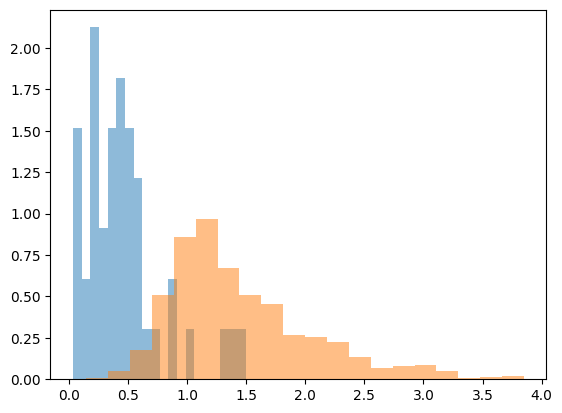

In [29]:
test_pos_distances, test_neg_distances = get_accuracy(test_pos_pairs, test_neg_pairs, images, threshold=0.65)
plt.hist(test_pos_distances, bins=20, density=True, alpha=0.5)
plt.hist(test_neg_distances, bins=20, density=True, alpha=0.5)
plt.show()